# Análisis de componentes principales con la base de datos de casas de California

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Cargamos el dataset de casas de California de ejercicios anteriores

In [ ]:
df = pd.read_feather('cdiae/data/03_model_input/california_housing_clean.ftr')
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
1,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
2,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
3,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
4,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992


In [37]:
X = df.drop(columns='target')
y = df['target']

In [38]:
print("Dimensiones del dataset:", df.shape)
df.head()

Dimensiones del dataset: (16393, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
1,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
2,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
3,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
4,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992


Estadísticas descriptivas:

In [39]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,16393.000000,16393.000000,16393.000000,16393.000000,16393.000000,16393.000000,16393.000000,16393.000000,16393.000000
mean,3.664875,29.491795,5.157438,1.047261,1270.523699,2.862434,35.668856,-119.627363,1.942280
std,1.448800,12.204684,1.044754,0.066532,627.220656,0.625743,2.139559,1.995430,0.964867
min,0.536000,1.000000,2.032738,0.866013,5.000000,1.161290,32.540000,-124.350000,0.149990
25%,2.563900,19.000000,4.425963,1.002770,812.000000,2.434066,33.940000,-121.820000,1.188000
50%,3.500000,30.000000,5.144289,1.043807,1158.000000,2.811881,34.290000,-118.600000,1.781000
75%,4.593800,38.000000,5.852735,1.088685,1635.000000,3.243553,37.730000,-118.030000,2.509000
max,8.011300,52.000000,8.452915,1.239521,3132.000000,4.560748,41.950000,-114.570000,5.000000


Verificamos si hay valores nulos por columna:

In [40]:
print(df.isnull().sum())

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
target        0
dtype: int64


### 1. Estandarizamos los datos antes de aplicar PCA
Transforma cada variable para que tenga media 0 y desvest 1.

In [41]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 2. Aplicamos la fórmula de PCA

In [42]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

### 3. Analizamos la varianza explicada por cada componente

In [43]:
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio

array([0.25813127, 0.22757364, 0.16138075, 0.13164551, 0.10670032,
       0.07958359, 0.02942719, 0.00555772])

In [44]:
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
cumulative_variance_ratio

array([0.25813127, 0.48570492, 0.64708567, 0.77873118, 0.8854315 ,
       0.96501509, 0.99444228, 1.        ])

### 4. Visualizamos la varianza explicada por cada componente:


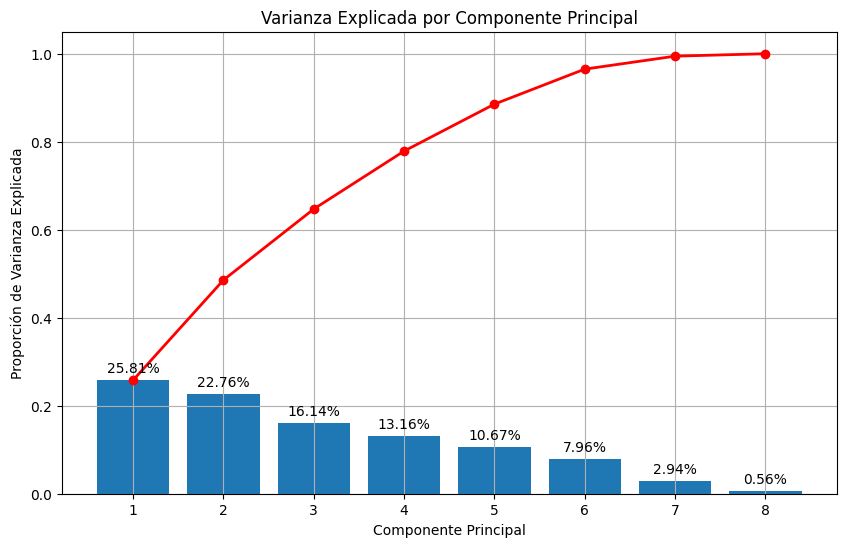

In [45]:
plt.figure(figsize=(10, 6))
bars = plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'r-o', linewidth=2)
plt.xlabel('Componente Principal')
plt.ylabel('Proporción de Varianza Explicada')
plt.title('Varianza Explicada por Componente Principal')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.grid(True)
# Añadir etiquetas de porcentaje a las barras
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{explained_variance_ratio[i]:.2%}', 
             ha='center', va='bottom', rotation=0)
plt.show()    

### 5. Determinar el número óptimo de componentes
Podemos elegir el número de componentes que expliquen al menos el 95% de la varianza

In [46]:
n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"\nNúmero de componentes para explicar al menos el 95% de la varianza: {n_components}")
print(f"Varianza acumulada explicada con {n_components} componentes: {cumulative_variance_ratio[n_components-1]:.4f}")


Número de componentes para explicar al menos el 95% de la varianza: 6
Varianza acumulada explicada con 6 componentes: 0.9650


Aplicamos PCA con el número óptimo de componentes

In [47]:
pca_optimal = PCA(n_components=n_components)
X_pca_optimal = pca_optimal.fit_transform(X_scaled)

In [48]:
print(f"\nDimensión original del dataset: {X.shape}")
print(f"Dimensión después de PCA: {X_pca_optimal.shape}")


Dimensión original del dataset: (16393, 8)
Dimensión después de PCA: (16393, 6)


### 6. Visualizamos los datos en las primeras 2 componentes principales

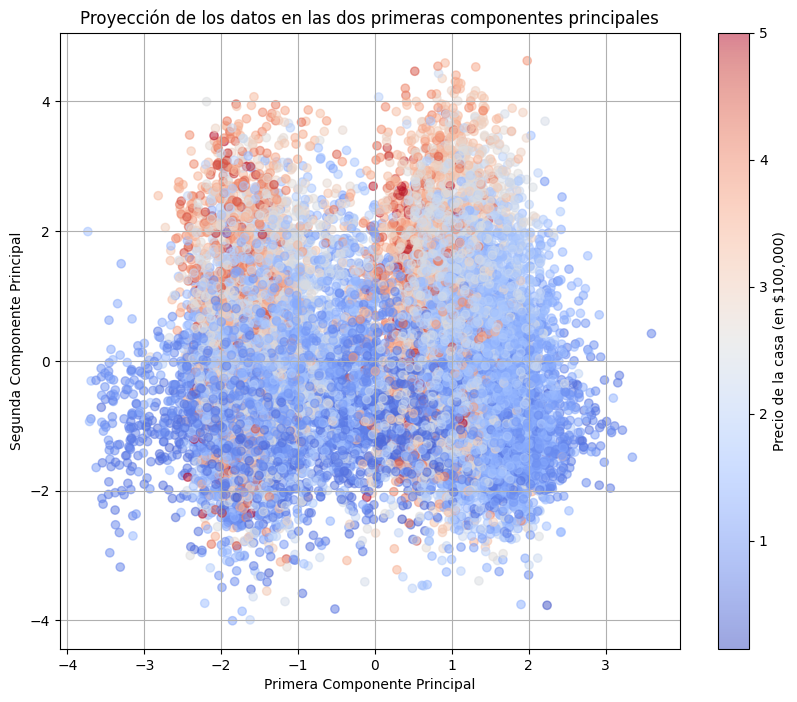

In [49]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.5)
plt.colorbar(scatter, label='Precio de la casa (en $100,000)')
plt.xlabel('Primera Componente Principal')
plt.ylabel('Segunda Componente Principal')
plt.title('Proyección de los datos en las dos primeras componentes principales')
plt.grid(True)
plt.show()

### 7. Analizamos la contribución de cada característica original a las componentes principales

In [50]:
loadings = pca.components_
feature_names = X.columns
loadings_df = pd.DataFrame(loadings.T, columns=[f'PC{i+1}' for i in range(loadings.shape[0])], index=feature_names)
loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
MedInc,-0.053582,0.667653,-0.171972,-0.044291,-0.022188,0.265505,-0.635084,0.213342
HouseAge,-0.075103,-0.316200,-0.543901,0.184500,0.397890,0.628773,0.079768,0.066883
AveRooms,-0.156802,0.633835,-0.014201,-0.115231,0.352539,0.036047,0.636352,-0.172220
AveBedrms,-0.010419,-0.187024,0.441736,-0.577323,0.605622,0.099366,-0.241348,0.039764
Population,0.211990,0.065305,0.629186,0.279659,-0.218551,0.639785,0.139654,0.010890
AveOccup,0.251751,0.081734,0.157538,0.685158,0.549737,-0.320224,-0.175595,0.009652
Latitude,-0.653063,-0.060711,0.198160,0.175781,0.010090,-0.084076,0.122010,0.691086
Longitude,0.657255,0.053855,-0.138939,-0.197151,0.007311,-0.063570,0.248776,0.664048


Por último, visualizamos la contribución de cada característica a las dos primeras componentes principales

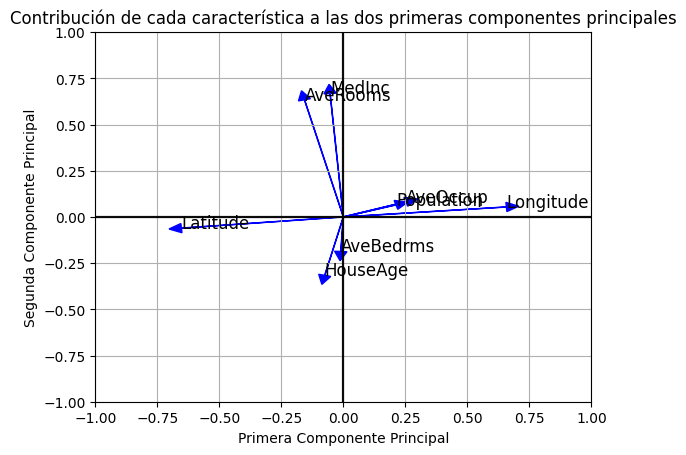

In [51]:
for i, feature in enumerate(feature_names):
    plt.arrow(0, 0, loadings[0, i], loadings[1, i], head_width=0.05, head_length=0.05, fc='blue', ec='blue')
    plt.text(loadings[0, i], loadings[1, i], feature, fontsize=12)
    plt.xlabel('Primera Componente Principal')
    plt.ylabel('Segunda Componente Principal')
    plt.title('Contribución de cada característica a las dos primeras componentes principales')
    plt.grid(True)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
plt.show()

### 8. Creamos un DataFrame con las puntuaciones de PCA para análisis adicionales

In [52]:
pca_df = pd.DataFrame(
    X_pca_optimal, 
    columns=[f'PC{i+1}' for i in range(X_pca_optimal.shape[1])]
)
pca_df['PRICE'] = y

In [53]:
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PRICE
0,-2.557713,2.677318,-1.706437,-0.315988,2.191342,1.203401,3.521
1,-2.211766,0.408397,-1.484934,-0.240594,1.133712,1.015440,3.413
2,-2.361362,-0.207574,-1.309934,-0.704669,1.066585,0.908831,3.422
3,-2.211877,-1.126679,-1.325145,-0.851760,0.772358,0.791207,2.697
4,-1.971013,-0.699725,-1.614279,0.752553,-0.797918,1.201384,2.992


### 9. Correlación entre las componentes principales y el precio

In [54]:
correlations = pca_df.corr()['PRICE'].drop('PRICE')
correlations

PC1   -0.058552
PC2    0.409986
PC3   -0.248207
PC4   -0.193862
PC5   -0.103978
PC6    0.407901
Name: PRICE, dtype: float64

Visualizamos las correlaciones:

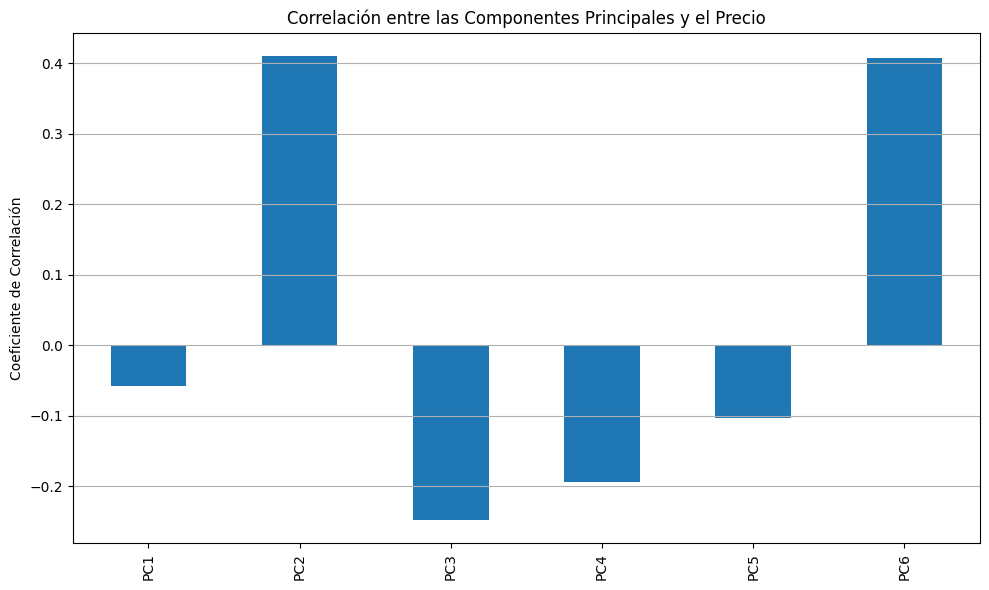

In [55]:
plt.figure(figsize=(10, 6))
correlations.plot(kind='bar')
plt.title('Correlación entre las Componentes Principales y el Precio')
plt.ylabel('Coeficiente de Correlación')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

### 10. Reconstruimos los datos originales a partir de las componentes principales

In [56]:
X_reconstructed = pca_optimal.inverse_transform(X_pca_optimal)
X_reconstructed = scaler.inverse_transform(X_reconstructed)

Calculamos el error (RMSE) de reconstrucción:

In [57]:
reconstruction_error = np.mean((X - X_reconstructed) ** 2)
np.sqrt(reconstruction_error)

np.float64(15.037696110866703)

Para una muestra comparamos los valores originales y reconstruidos:

In [58]:
sample_idx = 0
comparison_df = pd.DataFrame({
    'Original': X.iloc[sample_idx],
    'Reconstruido': X_reconstructed[sample_idx],
    'Diferencia': X.iloc[sample_idx].values - X_reconstructed[sample_idx]
})
comparison_df

,Original,Reconstruido,Diferencia
MedInc,7.257400,7.290982,-0.033582
HouseAge,52.000000,51.995750,0.004250
AveRooms,8.288136,8.265058,0.023078
AveBedrms,1.073446,1.073957,-0.000511
Population,496.000000,493.794964,2.205036
AveOccup,2.802260,2.805426,-0.003166
Latitude,37.850000,37.883328,-0.033328
Longitude,-122.240000,-122.217300,-0.022700


### Conclusiones del análisis PCA

In [59]:
print(f'- Hemos reducido la dimensionalidad de {X.shape[1]} a {n_components} componentes.')
print(f'- Estas {n_components} componentes explican el {cumulative_variance_ratio[n_components-1]:.2%} de la varianza total.')
print('- La PCA1 está más correlacionada con {}.'.format(feature_names[np.argmax(abs(loadings[0]))]))
print('- La segunda componente principal está más correlacionada con {}.'.format(feature_names[np.argmax(abs(loadings[1]))]))

- Hemos reducido la dimensionalidad de 8 a 6 componentes.
- Estas 6 componentes explican el 96.50% de la varianza total.
- La PCA1 está más correlacionada con Longitude.
- La segunda componente principal está más correlacionada con MedInc.


In [60]:
dominant_features = {f'PC{i+1}': loadings_df[f'PC{i+1}'].abs().idxmax() for i in range(n_components)}
print(dominant_features)

{'PC1': 'Longitude', 'PC2': 'MedInc', 'PC3': 'Population', 'PC4': 'AveOccup', 'PC5': 'AveBedrms', 'PC6': 'Population'}
